In [7]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import fix_yahoo_finance
import pandas as pd

## Importing Data From Yahoo API

In [9]:
def get(tickers, startdate, enddate):
    def data(ticker):
        return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
    datas = map (data, tickers)
    return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers = ['AAPL', 'MSFT', 'IBM', 'GOOG']

all_data = get(tickers, pd.datetime(2006,10,1), pd.datetime(2016,10,1))
all_data.head()


aapl = pdr.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2006, 10, 1), 
                          end=datetime.datetime(2016, 1, 1))
aapl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-10-02,10.838572,10.614285,10.728572,10.694285,178159800.0,7.103626
2006-10-03,10.707143,10.455714,10.635715,10.582857,197677200.0,7.029610
2006-10-04,10.780000,10.451428,10.585714,10.768572,207270700.0,7.152968
2006-10-05,10.880000,10.590000,10.647142,10.690000,170970800.0,7.100781
2006-10-06,10.720000,10.544286,10.631429,10.602858,116739700.0,7.042896


### Ordinary Least-Squares Regression (OLS)

In [17]:
# Import the `api` model of `statsmodels` under alias `sm`
import statsmodels.api as sm
from pandas import tseries
# from pandas.core import datetools

# Isolate the adjusted closing price
all_adj_close = all_data[['Adj Close']]

# Calculate the returns 
all_returns = np.log(all_adj_close / all_adj_close.shift(1))

# Isolate the AAPL returns 
aapl_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == 'AAPL']
aapl_returns.index = aapl_returns.index.droplevel('Ticker')

# Isolate the MSFT returns
msft_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == 'MSFT']
msft_returns.index = msft_returns.index.droplevel('Ticker')

return_data = pd.concat([aapl_returns, msft_returns], axis=1)[1:]

return_data.columns = ['AAPL', 'MSFT']

# Add a constant 
X = sm.add_constant(return_data['AAPL'])
# Construct the model
model = sm.OLS(return_data['MSFT'],X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     683.4
Date:                Fri, 07 Jun 2019   Prob (F-statistic):          1.85e-133
Time:                        17:43:47   Log-Likelihood:                 6879.8
No. Observations:                2517   AIC:                        -1.376e+04
Df Residuals:                    2515   BIC:                        -1.374e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.733e-06      0.000      0.028      0.9

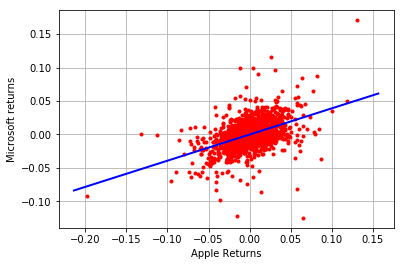

In [4]:
plt.plot(return_data['AAPL'], return_data['MSFT'], 'r.')

ax = plt.axis()
x = np.linspace(ax[0], ax[1] + 0.01)

plt.plot(x, model.params[0] + model.params[1] * x, 'b', lw=2)

plt.grid(True)
plt.axis('tight')
plt.xlabel('Apple Returns')
plt.ylabel('Microsoft returns')

plt.show()

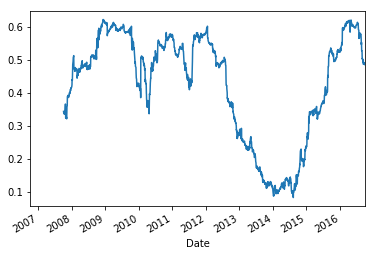

In [5]:
return_data['MSFT'].rolling(window=252).corr(return_data['AAPL']).plot()
plt.show()

## Building A Trading Strategy With Python(Moving Average Crossover)

In [10]:
# Initialize the short and long windows
short_window = 40
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=aapl.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = aapl['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = aapl['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

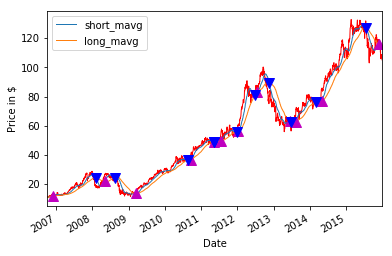

In [11]:
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
aapl['Close'].plot(ax=ax1, color='r', lw=1.)

# # Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=1.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='b')
         
# Show the plot
plt.show()

<a id='backtesting'></a>
## Backtesting A Strategy

### Implementation Of A Simple Backtester With Pandas

In [12]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['AAPL'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(aapl['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(aapl['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(aapl['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

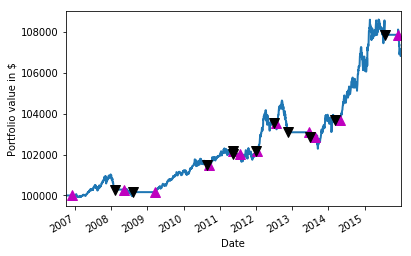

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

# Plot the "buy" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')

# Plot the "sell" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

## Evaluating Moving Average Crossover Strategy 

### Sharpe Ratio

In [14]:
# Higher the ratio the better portfolio is considered

# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

0.6690909267495494


### Compound Annual Growth Rate (CAGR)

In [15]:
# Get the number of days in `aapl`
days = (aapl.index[-1] - aapl.index[0]).days

# Calculate the CAGR 
cagr = ((((aapl['Adj Close'][-1]) / aapl['Adj Close'][1])) ** (365.0/days)) - 1

# Print CAGR
print(cagr)

0.3309819028682053
